# Stock Price Forecasting Project

In this project, I analyze and model the daily stock prices of three major companies: **Amazon (AMZN)**, **Microsoft (MSFT)**, and **IBM**. Using historical stock data from the past five years, I aim to explore trends, engineer features like moving averages and volatility, and build predictive models to forecast future prices.

The project uses the following tools:
- **Python** for data analysis and modeling
- **Pandas & yfinance** for data acquisition and manipulation
- **Matplotlib & Seaborn** for visualization
- **SQL** for data queries 
- **Tableau** for dashboarding and interactive insights


This end-to-end workflow simulates a real-world data science project and demonstrates my skills in data collection, preprocessing, modeling, and storytelling through visualizations.


## Modeling Plan

Since this dataset consists entirely of numerical time-series data, I will be using **regression models** to predict stock behavior. Specifically, I will focus on two outcome variables:

- **Next-Day Closing Price**: A direct prediction of the stock’s closing price for the following trading day.
- **Next-Day Percent Return**: A normalized prediction of the stock’s relative daily price change, calculated as the percent change in closing price from one day to the next.

To expand the range of modeling techniques I’ve used, I plan to go beyond the linear and LASSO models from previous projects. For this project, I will experiment with:

- **Random Forest Regressor**: A tree-based ensemble model that handles non-linear patterns well.
- **Gradient Boosting Regressor (XGBoost)**: A powerful boosting technique that often provides state-of-the-art performance.
- **Long Short-Term Memory (LSTM)** Neural Network: A deep learning model designed for sequential data, ideal for capturing time-based dependencies in stock prices.

These models will be trained on features engineered from historical stock data, including moving averages, volatility, and lagged prices. Model performance will be evaluated using appropriate regression metrics such as **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)**.


In [4]:
import yfinance as yf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

import pickle

In [5]:
os.makedirs("data", exist_ok=True)

# These are the labels used for the three specific stocks I am looking at
labels = ["AMZN", "MSFT", "IBM"]

# Now downloading and saving each one into the data folder
for label in labels:
    stock = yf.Ticker(label)
    df = stock.history(period="5y")  # last 5 years of daily data
    file_path = f"data/{label.lower()}_raw.csv"
    df.to_csv(file_path)
    print(f"Saved {label} data with {len(df)} rows to {file_path}")

Saved AMZN data with 1256 rows to data/amzn_raw.csv
Saved MSFT data with 1256 rows to data/msft_raw.csv
Saved IBM data with 1256 rows to data/ibm_raw.csv


In [6]:
amazon = pd.read_csv("data/amzn_raw.csv", index_col=False)
microsoft = pd.read_csv("data/msft_raw.csv", index_col=False)
ibm = pd.read_csv("data/ibm_raw.csv", index_col=False)
amazon.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-06-11 00:00:00-04:00,130.175003,133.569000,126.811501,127.898003,116002000,0.0,0.0
1,2020-06-12 00:00:00-04:00,130.060501,131.074005,125.167503,127.250999,108722000,0.0,0.0
2,2020-06-15 00:00:00-04:00,126.330002,129.199997,125.400002,128.634003,77302000,0.0,0.0
3,2020-06-16 00:00:00-04:00,131.000000,131.000000,128.800003,130.763504,71712000,0.0,0.0
4,2020-06-17 00:00:00-04:00,132.375000,132.750000,131.591003,132.048996,59186000,0.0,0.0


# Data Cleaning and Exploration

First it is very important to understand the data you are working with and understnd the questions you want to answer and reasoning behind it. First looking at the raw data it is split up into 8 different columns being:

- **Date**: The specific date the prices are on
- **Open**: The price at which the stock opens at on that specific day
- **High**: The highest price that specific stock reaches on that day
- **Low**: The lowest price that specific stock reaches on that day
- **Close**: What the stock price closes at on that day
- **Volume**: The total number of shares that were traded on that day (bought and sold). A higher volume often indicates stronger interest or volatility in the stock for that day.  
- **Dividends**: the amount of cash distributed to shareholder per share on that day. Most days this is 0 because most dividend-paying companies distribute it quarterly.
- **Stock Splits**: this shows any stock splits that occured on that day. A good example can be if a value of 2 is shwon there it would indicate that a 2-for-1 stock split occured. These can be rare but are important as they affect share count and price.

For this specific project I will be focusing more on **Open**, **High**, **Low**, **Close**, and **Volume**.

In [7]:
# Here I drop Dividends and Stock Splits from each data set. 
amazon.drop(columns=["Dividends", "Stock Splits"], inplace=True)
microsoft.drop(columns=["Dividends", "Stock Splits"], inplace=True)
ibm.drop(columns=["Dividends", "Stock Splits"], inplace=True)

# First I want to add a Label column that just shows the name of the company. This is important for when I combine the data sets into one it will have a clear distinction between the three companies.
amazon["Label"] = "AMZN"
microsoft["Label"] = "MSFT"
ibm["Label"] = "IBM"

# Here I am combining all data tables into a new data frame so it is easier to access
combined_df = pd.concat([amazon, microsoft, ibm], ignore_index=True)


**Descriptors of the now combined Data Set**

In [8]:
# Gathering some basic information about the data. This will help decide the type of models that should be used and what variables to use in those models.
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3768 entries, 0 to 3767
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3768 non-null   object 
 1   Open    3768 non-null   float64
 2   High    3768 non-null   float64
 3   Low     3768 non-null   float64
 4   Close   3768 non-null   float64
 5   Volume  3768 non-null   int64  
 6   Label   3768 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 206.2+ KB


In [9]:
combined_df.describe()

,Open,High,Low,Close,Volume
count,3768.000000,3768.000000,3768.000000,3768.000000,3.768000e+03
mean,202.129234,204.205634,200.001244,202.197135,3.163724e+07
std,94.834963,95.583248,94.047309,94.896428,3.030970e+07
min,82.800003,83.480003,81.430000,81.820000,1.186200e+06
25%,124.429349,125.739885,123.437879,124.690767,5.392375e+06
50%,174.943357,176.769997,173.256906,174.495476,2.429875e+07
75%,249.177595,251.920742,246.144459,248.988022,4.595645e+07
max,471.184998,473.429993,468.779999,472.750000,2.726620e+08


When working through this dataset, it was important to check for any duplicated or missing values. Given that the dataset contains daily stock prices, each row should correspond to a unique trading date — so duplicates are not expected. Using `.isna().sum()` confirmed that there were no missing values across any of the columns. Similarly, `.duplicated().sum()` verified that there were no duplicate rows in the dataset. These checks ensure that the data is clean and reliable before moving on to further analysis and feature engineering.


In [10]:
print(combined_df)

                           Date        Open        High         Low  \
0     2020-06-11 00:00:00-04:00  130.175003  133.569000  126.811501   
1     2020-06-12 00:00:00-04:00  130.060501  131.074005  125.167503   
2     2020-06-15 00:00:00-04:00  126.330002  129.199997  125.400002   
3     2020-06-16 00:00:00-04:00  131.000000  131.000000  128.800003   
4     2020-06-17 00:00:00-04:00  132.375000  132.750000  131.591003   
...                         ...         ...         ...         ...   
3763  2025-06-04 00:00:00-04:00  264.899994  267.000000  264.790009   
3764  2025-06-05 00:00:00-04:00  265.200012  267.510010  265.100006   
3765  2025-06-06 00:00:00-04:00  267.989990  270.170013  267.529999   
3766  2025-06-09 00:00:00-04:00  268.100006  273.470001  266.709991   
3767  2025-06-10 00:00:00-04:00  273.190002  277.470001  272.559998   

           Close     Volume Label  
0     127.898003  116002000  AMZN  
1     127.250999  108722000  AMZN  
2     128.634003   77302000  AMZN  
3  

**What I Observed:**
- Data was clean and organizaed with no missing or duplicated values
- Based on the numerical structure of the data points it is important to go forward with  correct models that will produce the highest accuracy.
    - In this case: Random Forest, XGBoost, and LSTM
- The data set can definitely be more advnaced with feature engineering and should begin creating new variables that can enhance model performance.
    - New variable ideas based on original viewing of data set: Daily Return, Moving Averages, Volatility
    - And make sure to include the future prediciton targets


Overall, this dataset was already well-organized and required minimal cleaning. However, it’s important to remember that data cleaning involves more than just the values themselves, it also includes how the data is structured and presented. For example, inconsistently formatted column titles should be standardized, noisy or irrelevant data should be removed, and duplicate entries should be eliminated. These steps are all crucial to ensuring the dataset is clean, reliable, and ready for analysis. 

**Feature Engineering**
1. Daily_Return. This will measure the percent change in closing price from the previous trading day. This cpatures short-term momentum or reversal patterns in the stock's prices.


In [11]:
combined_df['Daily_Return'] = combined_df.groupby('Label')['Close'].pct_change()

2. MA_7. This is a 7-Day Moving Average varaible. This will show the average closing price over the past 7 trading days. Helps smooth out short-term fluctuations and highlights recent price trends

In [12]:
combined_df['MA_7'] = combined_df.groupby('Label')['Close'].rolling(7).mean().reset_index(level=0, drop=True)

3. Lag_Close_1. This is the closing price from the previous day. This lagged value gives the moel immediate historical context and helps identify short-term dependencies in the price behavior. 

In [13]:
combined_df['Lag_Close_1'] = combined_df.groupby('Label')['Close'].shift(1)

In [14]:
combined_df.dropna(inplace=True)

In [15]:
print(combined_df)

                           Date        Open        High         Low  \
6     2020-06-19 00:00:00-04:00  133.904007  134.871506  132.949997   
7     2020-06-22 00:00:00-04:00  134.225006  135.750000  133.449997   
8     2020-06-23 00:00:00-04:00  136.300995  139.155502  135.901993   
9     2020-06-24 00:00:00-04:00  139.000000  139.800003  136.050003   
10    2020-06-25 00:00:00-04:00  136.977493  137.811493  135.606995   
...                         ...         ...         ...         ...   
3763  2025-06-04 00:00:00-04:00  264.899994  267.000000  264.790009   
3764  2025-06-05 00:00:00-04:00  265.200012  267.510010  265.100006   
3765  2025-06-06 00:00:00-04:00  267.989990  270.170013  267.529999   
3766  2025-06-09 00:00:00-04:00  268.100006  273.470001  266.709991   
3767  2025-06-10 00:00:00-04:00  273.190002  277.470001  272.559998   

           Close     Volume Label  Daily_Return        MA_7  Lag_Close_1  
6     133.750504  115540000  AMZN      0.007924  130.435002   132.699005

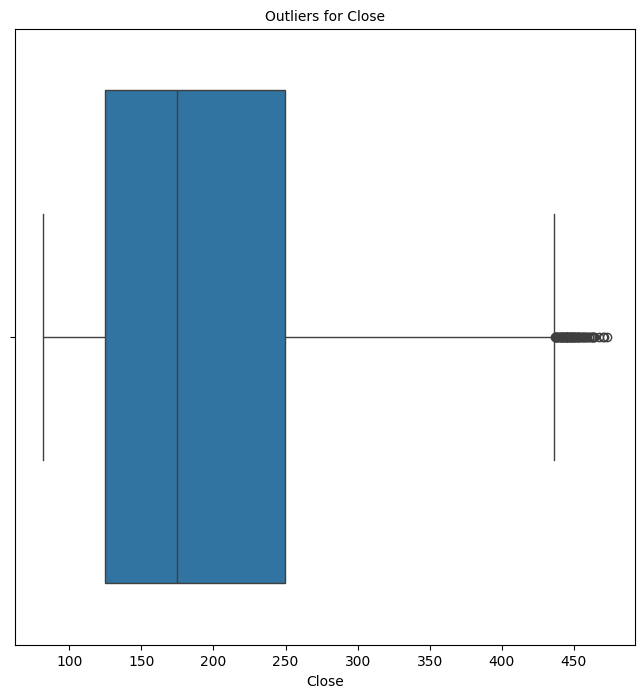

In [16]:
plt.figure(figsize=(8,8))
plt.title('Outliers for Close', fontsize =10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
sns.boxplot(x = combined_df['Close'])
plt.show()

## Interpreting Outliers in Closing Prices ##

After creating a boxplot of the `Close` column, it became clear that there are several outliers on the higher end of the distribution. These outliers are not due to errors or anomalies, but are instead a reflection of a differing of closing prices between the three companies. This is expected in a dataset combining multiple companies with different market values.

However, this price disparity may cause issues when training machine learning models — particularly those that are sensitive to scale. Models may unintentionally prioritize fitting a certain values over the others, potentially reducing accuracy and fairness across the dataset. To address this, I plan to either model each stock individually or use `percent return` as the outcome variable instead of raw closing price.


In [34]:
# Here I am creating my two target variables that I will be running models in order to predict.

# Target_Return is the percent change in the stock's closing price from one day to the next trading day.
# This will give me a nromazlied measure of how much the price changes from one day to the next in either direction.
# This can help answer questions like: Will the stock likely go up or down tomorrow or by how much?
combined_df['Target_Return'] = (combined_df.groupby('Label')['Close'].shift(-1) - combined_df['Close']) / combined_df['Close']

# Target_Close shifts the next day's closing price upward one row so that each day contains the regular variables and then tomorrow's actual closing price so our model can learn to predict tomorrow's clsoing price using today's data.
combined_df['Target_Close'] = combined_df.groupby('Label')['Close'].shift(-1)
combined_df.dropna(inplace=True)


**Visualizations**


## High Correlation Between Price Features

After generating a correlation heatmap, it became clear that many of the original and engineered price-related features — such as `Open`, `High`, `Low`, `Close`, `Lag_Close_1`, and `MA_7` — are extremely highly correlated with each other (with correlation values above 0.99). This is expected in stock price data, as these values typically move together within a narrow daily range, especially for large-cap stocks like Amazon, Microsoft, and IBM.

While this level of correlation isn't inherently bad, it does indicate redundancy in the feature set. Including multiple highly correlated variables can introduce noise or unnecessary complexity in some models.

To address this, I will:
- Focus on a **reduced set of meaningful features**, such as `Close`, `Volume`, `Daily_Return`, `MA_7`, and `Lag_Close_1`.
- Use models like **Random Forest** that are less sensitive to multicollinearity.
- Shift focus away from correlation heatmaps and instead explore **more meaningful visualizations**, such as time series plots, return distributions, and actual vs predicted plots.


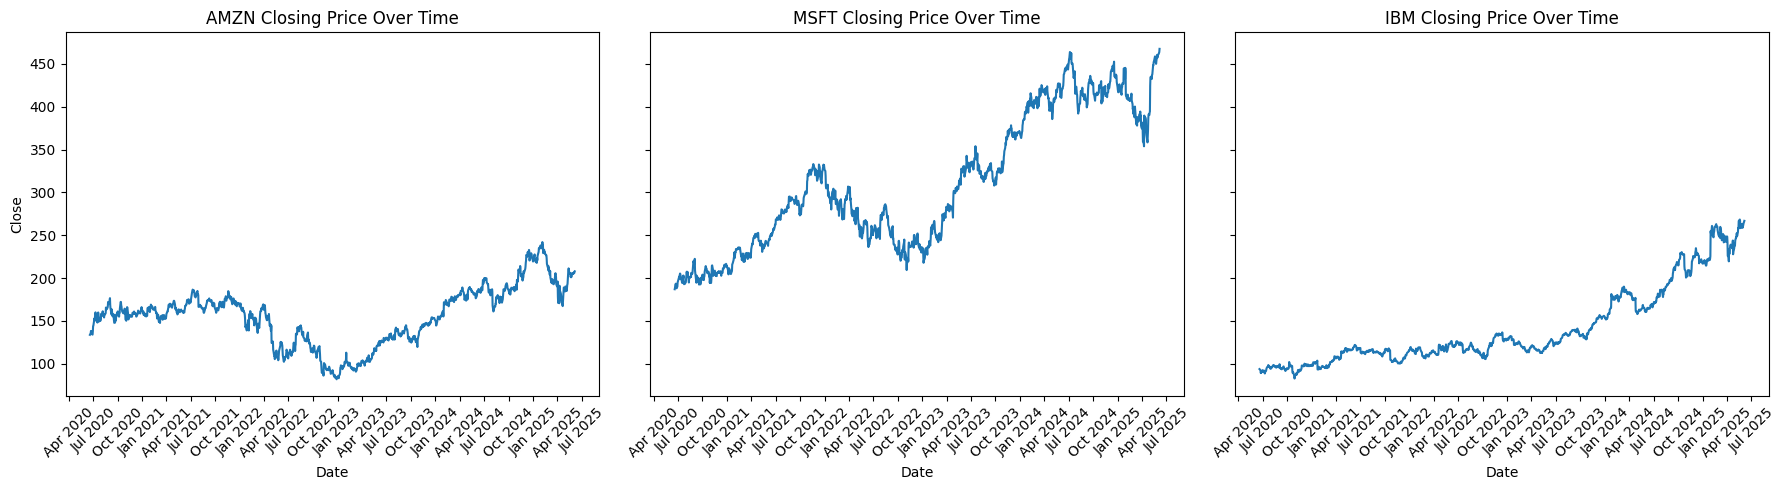

In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

# Ensure datetime format
combined_df['Date'] = pd.to_datetime(combined_df['Date'], utc=True)

# Set up the 3-panel subplot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharey=True)

# Tickers to plot
tickers = ['AMZN', 'MSFT', 'IBM']

for i, label in enumerate(labels):
    ax = axes[i]
    stock_df = combined_df[combined_df['Label'] == label].copy()
    
    sns.lineplot(data=stock_df, x='Date', y='Close', ax=ax)
    ax.set_title(f"{label} Closing Price Over Time")
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


## Closing Price Trends for AMZN, MSFT, and IBM

The three line plots above illustrate the historical closing prices for Amazon (AMZN), Microsoft (MSFT), and IBM over the past five years.

- **Amazon (AMZN)**: The closing price shows a period of volatility, with a noticeable dip in 2022 followed by gradual recovery. The stock experienced several cycles of ups and downs, reflecting broader market movements and possibly company-specific events.

- **Microsoft (MSFT)**: The stock demonstrates a strong upward trend over the five-year period, with relatively consistent growth. Temporary dips are visible, likely corresponding with market corrections, but the overall trajectory is positive and steep.

- **IBM**: IBM’s price movement is more stable and modest compared to AMZN and MSFT. While there is growth in the later years, the trend is less aggressive, indicating slower stock appreciation over time.

These visualizations highlight the different behaviors of each company's stock, which is important context when building models — especially when combining all three into one predictive dataset.


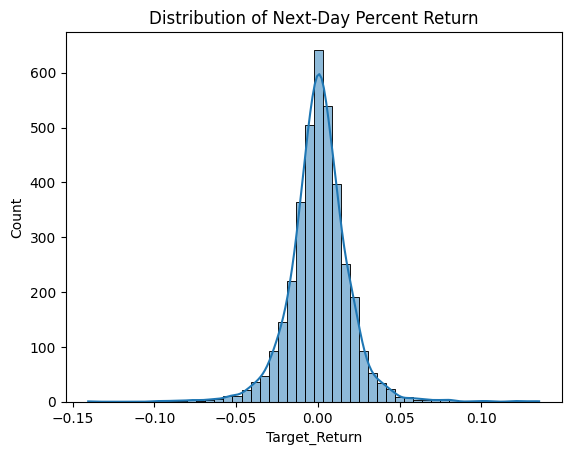

In [51]:
sns.histplot(combined_df['Target_Return'], bins=50, kde=True)
plt.title("Distribution of Next-Day Percent Return")
plt.xlabel("Target_Return")
plt.show()


The histogram above shows the distribution of `Target_Return` (next-day percent return) across all three stocks. The distribution is centered around zero and closely resembles a normal distribution. This suggests that most next-day returns are small in magnitude, with extreme positive or negative returns being relatively rare — which is typical in daily stock market movement.


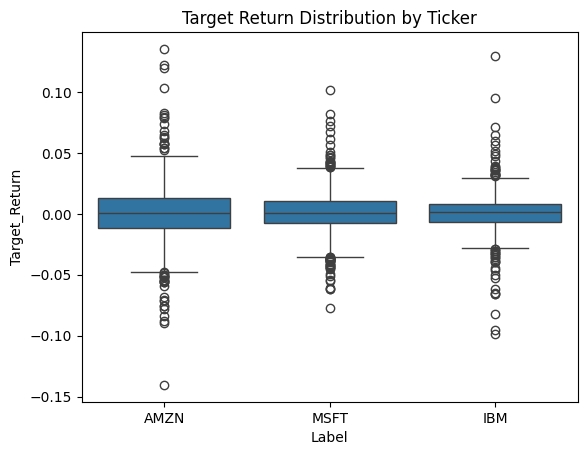

In [54]:
sns.boxplot(data=combined_df, x='Label', y='Target_Return')
plt.title("Target Return Distribution by Ticker")
plt.show()


This boxplot compares the distribution of `Target_Return` across Amazon (AMZN), Microsoft (MSFT), and IBM. Each stock shows a similar pattern of tightly centered returns around zero, with a number of outliers on both the positive and negative sides. This suggests that while the three stocks behave similarly in terms of daily percent return, there are occasional large movements that could influence model training and evaluation.


## Model Creation #1 : Random Forest Regressor

In [56]:
# For the first model I will create a random forest regressor that is good for a baseline model and is simple/robust.
# First I want to set what variables I will be using, my target varible and set them up for training/testing.

# Define features and target
features = ['Close', 'Volume', 'Daily_Return', 'MA_7', 'Lag_Close_1']
target = 'Target_Return'

X = combined_df[features]
y = combined_df[target]

In [57]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle = False)

In [58]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.010700912915311587
RMSE: 0.015342520381929063


## Random Forest Model Evaluation (Target: Percent Return)

After training a Random Forest Regressor to predict the next-day percent return (`Target_Return`), the model achieved the following performance on the test set:

- **Mean Absolute Error (MAE): 0.0107**
- **Root Mean Squared Error (RMSE): 0.0153**

These results indicate that the model's predictions are, on average, within **1.07%** of the actual next-day return, with occasional larger errors that raise the RMSE to approximately **1.53%**. This level of error is quite reasonable for financial time series data, where daily returns typically fall within a small range.

Overall, the model provides a solid foundation for understanding short-term stock return behavior and serves as a reliable baseline for comparison with more advanced models such as XGBoost and LSTM.


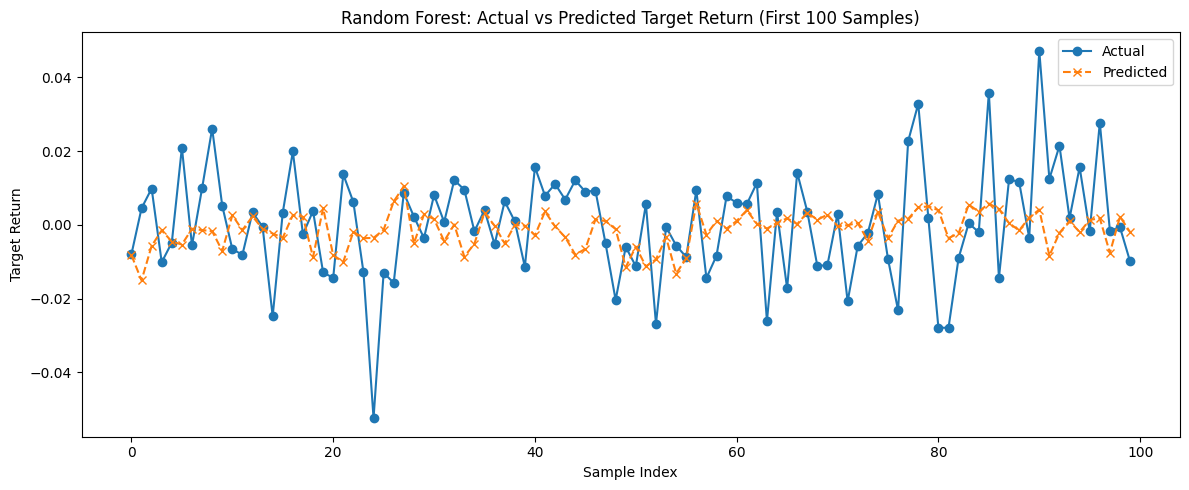

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label="Actual", marker='o', linestyle='-')
plt.plot(y_pred[:100], label="Predicted", marker='x', linestyle='--')
plt.title("Random Forest: Actual vs Predicted Target Return (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Target Return")
plt.legend()
plt.tight_layout()
plt.show()
